# 0.0 Understand the Problem

- Purpose of the problem:
    - 1.0 Prediction of the first destination that a new user will choose.
        
    -- Why?
        - What kind of Airbnb business model?
            - Marketplace (Connects people who offer accommodation, with people looking for accommodation)
            - Offer (people offering accommodation)
                - Portfolio Size
                - Diversity / Density of the Portfolio
                - Average rental price
                                
            - Demand (people looking for accommodation)
                - Number of users
                - LTV (Lifetime Value)
                - CAC (Client Acquisition Cost)
                
                
                Gross Revenue = (Fee * Customer Number) - CAC
        
- Solution Proposition <br>

    - Forecast model of the first destination of a new user
    - 1.0 Predictions and save to a database table
    - 2.0 API
        - Input: user and its characteristics
        - Output: user and its characteristics with ** destination prediction **
        
    - 16 cycles

# <font color='red'> Ciclo05: Balanced Dataset </font>

## 0.0 Imports

In [177]:
import pandas                                     as pd
import numpy                                      as np
import seaborn                                    as sns

from IPython.core.display  import HTML
from sklearn               import model_selection as ms
from sklearn               import preprocessing   as pp
from sklearn               import metrics         as m

from keras                 import models          as ml
from keras                 import layers          as l

from scikitplot            import metrics         as mt
from scipy                 import stats           as ss

### 0.1 Helper Functions

In [178]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

In [179]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


/home/victorpereira/.pyenv/versions/3.8.0/envs/airbnb_predict_first_booking/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


### 0.2 Loading Data

In [180]:
df_raw = pd.read_csv( 'data/train_users_2.csv', low_memory=True )
df_raw.shape

(213451, 16)

In [181]:
df_sessions = pd.read_csv( 'data/sessions.csv', low_memory=True )
df_sessions.shape

(10567737, 6)

## 1.0 Data Description

In [182]:
df1 = df_raw.copy()

### 1.1 Data Dimension

In [183]:
print( 'Number of rows: {}'.format( df1.shape[0]) )
print( 'Number of columns: {}'.format( df1.shape[1]) )

Number of rows: 213451
Number of columns: 16


In [184]:
print( 'Number of rows: {}'.format( df_sessions.shape[0]) )
print( 'Number of columns: {}'.format( df_sessions.shape[1]) )

Number of rows: 10567737
Number of columns: 6


### 1.2 Data Type

In [185]:
df1.dtypes

id                          object
date_account_created        object
timestamp_first_active       int64
date_first_booking          object
gender                      object
age                        float64
signup_method               object
signup_flow                  int64
language                    object
affiliate_channel           object
affiliate_provider          object
first_affiliate_tracked     object
signup_app                  object
first_device_type           object
first_browser               object
country_destination         object
dtype: object

In [186]:
df_sessions.dtypes

user_id           object
action            object
action_type       object
action_detail     object
device_type       object
secs_elapsed     float64
dtype: object

In [187]:
df1.sample().T

,198030
id,7w0zp8jf7j
date_account_created,2014-06-01
timestamp_first_active,20140601213100
date_first_booking,2014-06-01
gender,MALE
age,31
signup_method,basic
signup_flow,0
language,en
affiliate_channel,seo


### 1.3 NA Check

In [188]:
df1.isna().sum() / len( df1 )

id                         0.000000
date_account_created       0.000000
timestamp_first_active     0.000000
date_first_booking         0.583473
gender                     0.000000
age                        0.412226
signup_method              0.000000
signup_flow                0.000000
language                   0.000000
affiliate_channel          0.000000
affiliate_provider         0.000000
first_affiliate_tracked    0.028414
signup_app                 0.000000
first_device_type          0.000000
first_browser              0.000000
country_destination        0.000000
dtype: float64

In [189]:
df_sessions.isna().sum() / len( df1 )

user_id          0.161611
action           0.373041
action_type      5.276171
action_detail    5.276171
device_type      0.000000
secs_elapsed     0.637294
dtype: float64

In [190]:
# remoe missing values completly
#df1 = df1.dropna()

# ========== User ==========

# date_first_booking
date_first_booking_max = pd.to_datetime( df1['date_first_booking'] ).max().strftime( '%Y-%m-%d' )
df1['date_first_booking' ] = df1['date_first_booking'].fillna( date_first_booking_max )

# age

df1 = df1[( df1['age'] > 15 ) & ( df1['age'] < 120 )]
avg_age = df1['age'].mean().astype( int )
df1['age'] = df1['age'].fillna( avg_age )

#first_affiliate_tracked
df1 = df1[~df1['first_affiliate_tracked'].isna()]

# ========== Sessions ==========

# user_id - 0.3%
df_sessions = df_sessions[~df_sessions['user_id'].isna()]

# action - 0.7%
df_sessions = df_sessions[~df_sessions['action'].isna()]

# action_type - 11%
df_sessions = df_sessions[~df_sessions['action_type'].isna()]

# action_detail - 11%
df_sessions = df_sessions[~df_sessions['action_detail'].isna()]

# secs_elapsed - 1.2%
df_sessions = df_sessions[~df_sessions['secs_elapsed'].isna()]


In [191]:
aux = df1[df1['date_first_booking'].isna()]
aux['country_destination'].value_counts( normalize=True )
# Only the NDF has missing values in this variable. 
# The reason for this occur is that the person didn't do the first booking yet.
# The value that we will fill the missing values is the max day in the 'date_first_booking' column.

Series([], Name: country_destination, dtype: float64)

In [192]:
aux = df1[df1['age'].isna()]
aux['country_destination'].value_counts( normalize=True )

# We can see here that the missing values is proporcional distribuciones among the target values.
# Let's plot a graph which will give us a better visualization of this distribution.

Series([], Name: country_destination, dtype: float64)

/home/victorpereira/.pyenv/versions/3.8.0/envs/airbnb_predict_first_booking/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='age', ylabel='Density'>

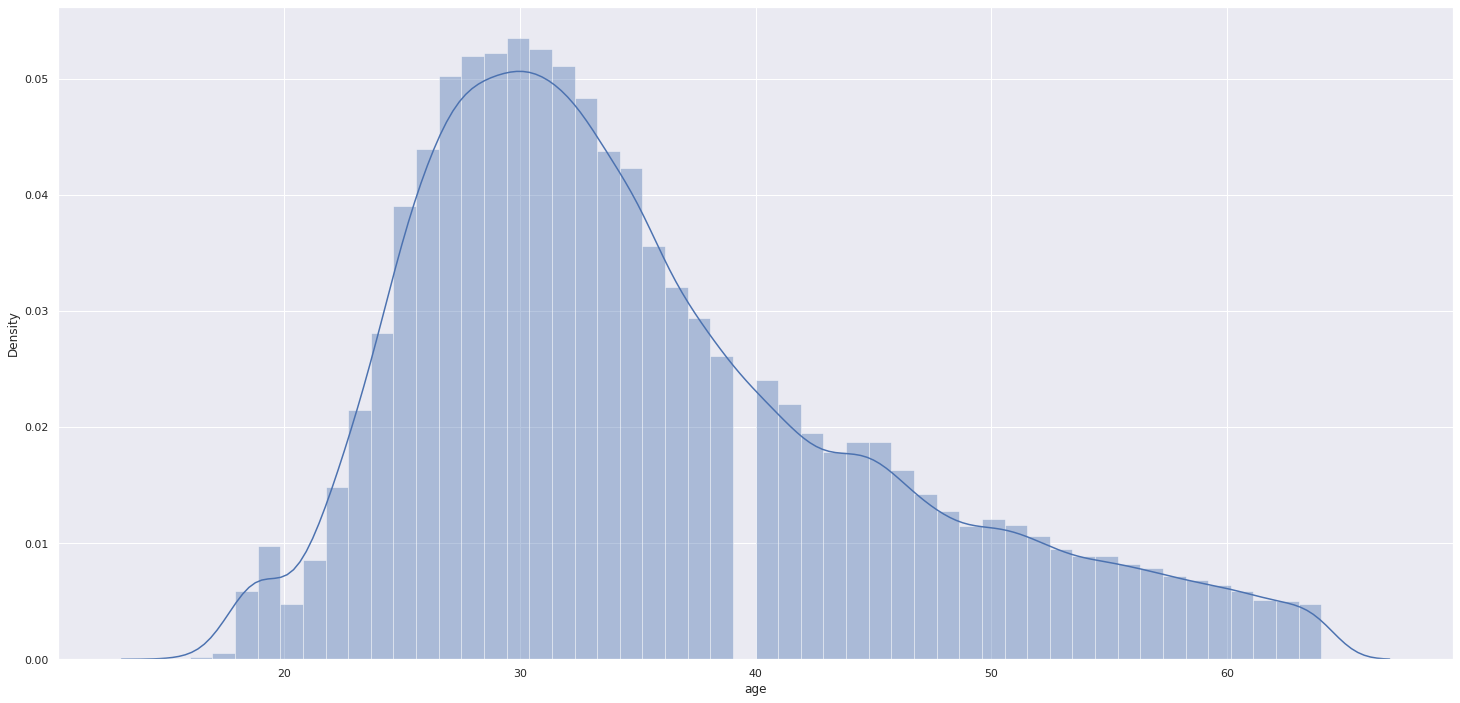

In [193]:
sns.distplot( df1[df1['age'] < 65]['age'] )
# We can see that this variable has a Normal distribution.
# For this reason, in this variable, I will use "mean" to fill the missing values.

In [194]:
df1['first_affiliate_tracked'].drop_duplicates()
# This is a categorical variable. It's very difficult to fill out categorical variables.
# Normally you fill using the frequency method, but the chance to input a bias in the dataset is big.
# As the number of missing values in this case is not so large, I will just drop them. 

1            untracked
7                  omg
13              linked
79       tracked-other
257            product
7082         marketing
13228        local ops
Name: first_affiliate_tracked, dtype: object

In [195]:
df1.isna().sum()

id                         0
date_account_created       0
timestamp_first_active     0
date_first_booking         0
gender                     0
age                        0
signup_method              0
signup_flow                0
language                   0
affiliate_channel          0
affiliate_provider         0
first_affiliate_tracked    0
signup_app                 0
first_device_type          0
first_browser              0
country_destination        0
dtype: int64

In [196]:
df_sessions.isna().sum()

user_id          0
action           0
action_type      0
action_detail    0
device_type      0
secs_elapsed     0
dtype: int64

### 1.4 Change Data Type

In [197]:
# date_account_created
df1['date_account_created'] = pd.to_datetime( df1['date_account_created'] )

# timestamp_first_active
df1['timestamp_first_active'] = pd.to_datetime( df1['timestamp_first_active'], format='%Y%m%d%H%M%S' )

# date_first_booking
df1['date_first_booking'] = pd.to_datetime( df1['date_first_booking'] )

# age
df1['age'] = df1['age'].astype( int )

In [198]:
df1.dtypes

id                                 object
date_account_created       datetime64[ns]
timestamp_first_active     datetime64[ns]
date_first_booking         datetime64[ns]
gender                             object
age                                 int64
signup_method                      object
signup_flow                         int64
language                           object
affiliate_channel                  object
affiliate_provider                 object
first_affiliate_tracked            object
signup_app                         object
first_device_type                  object
first_browser                      object
country_destination                object
dtype: object

### 1.5 Check Balanced Data

In [199]:
df1['country_destination'].value_counts( normalize=True )

NDF      0.447275
US       0.391867
other    0.061246
FR       0.029918
IT       0.016423
GB       0.014335
ES       0.013740
CA       0.008676
DE       0.006858
NL       0.004852
AU       0.003531
PT       0.001280
Name: country_destination, dtype: float64

### 1.6 Descriptive Analysis

In [200]:
# Users

num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )
time_attributes = df1.select_dtypes( include=['datetime64[ns]'] )

# Sessions

num_attributes_sessions = df_sessions.select_dtypes( include=['int64', 'float64'] )
cat_attributes_sessions = df_sessions.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )
time_attributes_sessions = df_sessions.select_dtypes( include=['datetime64[ns]'] )

#### 1.6.1 Numerical - Users

In [201]:
# Central Tendency - Mean, Median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersions - Std, Min, Max, Range, Skew, Kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# Concatenated
ct = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
ct.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
ct

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,age,16.0,115.0,99.0,37.405591,34.0,13.939844,2.089718,6.516468
1,signup_flow,0.0,25.0,25.0,2.519513,0.0,6.604696,2.705871,5.928298


#### 1.6.2 Numerical - Sessions

In [202]:
# Central Tendency - Mean, Median
ct1 = pd.DataFrame( num_attributes_sessions.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes_sessions.apply( np.median ) ).T

# Dispersions - Std, Min, Max, Range, Skew, Kurtosis
d1 = pd.DataFrame( num_attributes_sessions.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes_sessions.apply( min ) ).T
d3 = pd.DataFrame( num_attributes_sessions.apply( max ) ).T
d4 = pd.DataFrame( num_attributes_sessions.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes_sessions.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes_sessions.apply( lambda x: x.kurtosis() ) ).T

# Concatenated
ct = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
ct.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
ct

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,secs_elapsed,0.0,1799977.0,1799977.0,19961.8251,1369.0,88849.388449,11.137761,154.84312


#### 1.6.3 Categorical - Users

In [203]:
cat_attributes.drop( 'id', axis=1 ).describe()

,gender,signup_method,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
count,122636,122636,122636,122636,122636,122636,122636,122636,122636,122636
unique,4,3,25,8,17,7,4,9,41,12
top,FEMALE,basic,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
freq,56362,66039,118205,79093,78954,64712,108283,57943,41778,54852


#### 1.6.4 Categorical - Sessions

In [204]:
cat_attributes_sessions.drop( 'user_id', axis=1 ).describe()

,action,action_type,action_detail,device_type
count,9213930,9213930,9213930,9213930
unique,347,10,155,14
top,show,view,view_search_results,Mac Desktop
freq,2178382,3545621,1770931,3019523


In [205]:
# List of attributes for Cramer's V correlation
cat_attributes_list = cat_attributes_sessions.drop( 'user_id', axis=1 ).columns.tolist()

corr_dict = {}
for i in range ( len( cat_attributes_list ) ):
    corr_list = []
    for j in range( len( cat_attributes_list ) ):
        ref = cat_attributes_list[i]
        feat = cat_attributes_list[j]
        
        # correlation
        corr = cramer_v( cat_attributes_sessions[ ref ], cat_attributes_sessions[ feat ] )
        
        # append a list
        corr_list.append( corr )
    
    # append a correlation list for each ref attributs
    corr_dict[ ref ] = corr_list

<AxesSubplot:>

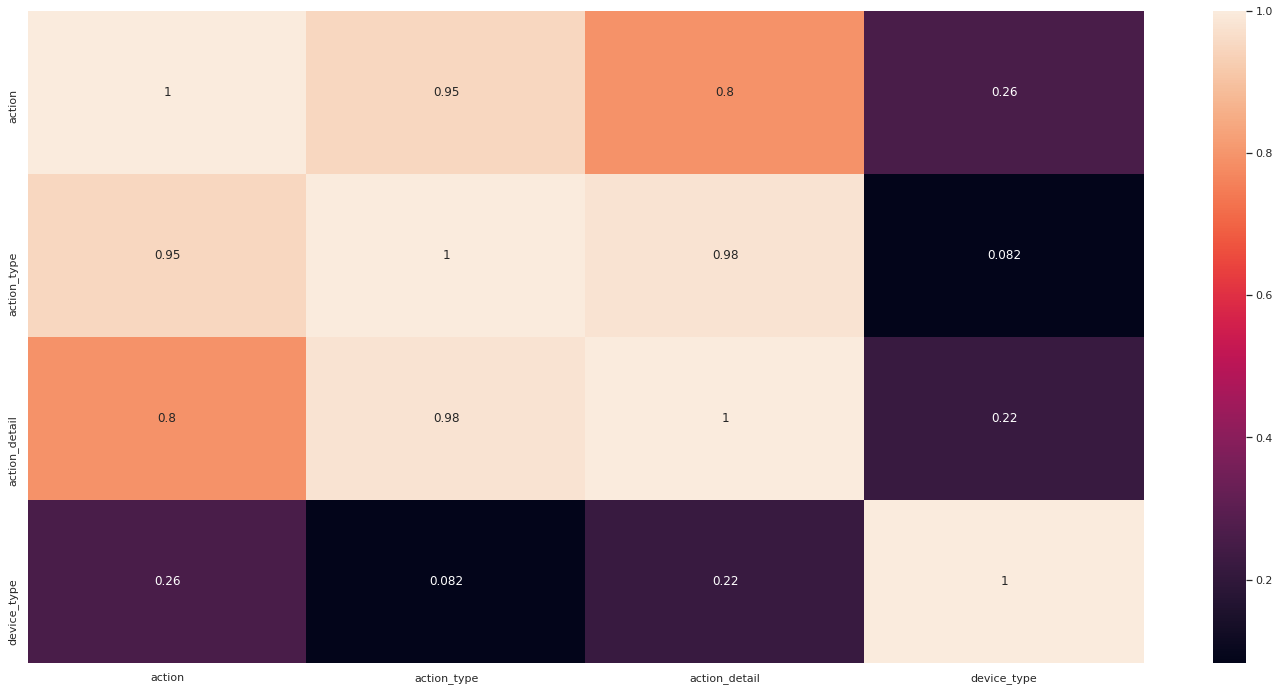

In [206]:
d = pd.DataFrame( corr_dict )
d = d.set_index( d.columns )
sns.heatmap( d, annot=True )

## 2.0 Feature Engineering

In [207]:
df2 = df1.copy()

### 2.1 Create New Features

In [208]:
# days from first active up to first booking
df2['first_active'] = pd.to_datetime( df2['timestamp_first_active'].dt.strftime( '%Y-%m-%d' ) )
df2['days_from_first_active_until_booking'] = ( df2['date_first_booking'] - df2['first_active'] ).apply( lambda x: x.days )

# days from active up to account created
df2['days_from_first_active_account_created'] = ( df2['date_account_created'] - df2['first_active'] ).apply( lambda x: x.days )

# days from account created up to first booking
df2['days_from_account_created_until_first_booking'] = ( df2['date_first_booking'] - df2['first_active'] ).apply( lambda x: x.days )

# ====================== First Active ====================
# year first active
df2['year_first_active'] = df2['first_active'].dt.year

# month first active
df2['month_first_active'] = df2['first_active'].dt.month

# day first active
df2['day_first_active'] = df2['first_active'].dt.day

# week of year first active
df2['week_of_year_first_active'] = df2['first_active'].dt.weekofyear

# day_of_week first active
df2['day_of_week_first_active'] = df2['first_active'].dt.dayofweek

# ======================= First Booking ==================
# year first booking
df2['year_first_booking'] = df2['date_first_booking'].dt.year

# month first booking
df2['month_first_booking'] = df2['date_first_booking'].dt.month

# day first booking
df2['day_first_booking'] = df2['date_first_booking'].dt.day

# week of year first booking
df2['week_of_year_first_booking'] = df2['date_first_booking'].dt.weekofyear

# day_of_week first booking
df2['day_of_week_first_booking'] = df2['date_first_booking'].dt.dayofweek

# ======================= First Account Created ==================
# year first booking
df2['year_account_created'] = df2['date_account_created'].dt.year

# month first booking
df2['month_account_created'] = df2['date_account_created'].dt.month

# day first booking
df2['day_account_created'] = df2['date_account_created'].dt.day

# week of year first booking
df2['week_of_year_account_created'] = df2['date_account_created'].dt.weekofyear

# day_of_week first booking
df2['day_of_week_account_created'] = df2['date_account_created'].dt.dayofweek

<ipython-input-208-85668a42cdf0>:22: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df2['week_of_year_first_active'] = df2['first_active'].dt.weekofyear
<ipython-input-208-85668a42cdf0>:38: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df2['week_of_year_first_booking'] = df2['date_first_booking'].dt.weekofyear
<ipython-input-208-85668a42cdf0>:54: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df2['week_of_year_account_created'] = df2['date_account_created'].dt.weekofyear


In [209]:
df2.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,first_active,days_from_first_active_until_booking,days_from_first_active_account_created,days_from_account_created_until_first_booking,year_first_active,month_first_active,day_first_active,week_of_year_first_active,day_of_week_first_active,year_first_booking,month_first_booking,day_first_booking,week_of_year_first_booking,day_of_week_first_booking,year_account_created,month_account_created,day_account_created,week_of_year_account_created,day_of_week_account_created
1,820tgsjxq7,2011-05-25,2009-05-23 17:48:09,2015-06-29,MALE,38,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF,2009-05-23,2228,732,2228,2009,5,23,21,5,2015,6,29,27,0,2011,5,25,21,2
2,4ft3gnwmtx,2010-09-28,2009-06-09 23:12:47,2010-08-02,FEMALE,56,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US,2009-06-09,419,476,419,2009,6,9,24,1,2010,8,2,31,0,2010,9,28,39,1
3,bjjt8pjhuk,2011-12-05,2009-10-31 06:01:29,2012-09-08,FEMALE,42,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other,2009-10-31,1043,765,1043,2009,10,31,44,5,2012,9,8,36,5,2011,12,5,49,0
4,87mebub9p4,2010-09-14,2009-12-08 06:11:05,2010-02-18,-unknown-,41,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US,2009-12-08,72,280,72,2009,12,8,50,1,2010,2,18,7,3,2010,9,14,37,1
6,lsw9q7uk0j,2010-01-02,2010-01-02 01:25:58,2010-01-05,FEMALE,46,basic,0,en,other,craigslist,untracked,Web,Mac Desktop,Safari,US,2010-01-02,3,0,3,2010,1,2,53,5,2010,1,5,1,1,2010,1,2,53,5


In [210]:
df2.dtypes

id                                                       object
date_account_created                             datetime64[ns]
timestamp_first_active                           datetime64[ns]
date_first_booking                               datetime64[ns]
gender                                                   object
age                                                       int64
signup_method                                            object
signup_flow                                               int64
language                                                 object
affiliate_channel                                        object
affiliate_provider                                       object
first_affiliate_tracked                                  object
signup_app                                               object
first_device_type                                        object
first_browser                                            object
country_destination                     

In [211]:
df2.shape

(122636, 35)

## 3.0 Data Filtering

In [212]:
df3 = df2.copy()

### 3.1 Filtering Rows

In [213]:
# Filtering rows:
# age - greater than 15 and lower than 120 - There are few people over 120 years old
df3 = df3[( df3['age'] > 15 ) & ( df3['age'] < 120 )]

# secs_elapsed - there is no possible 0 secs elapsed on website
#df3 = df3[df3['secs_elapsed'] > 0]

### 3.2 Column Selection

## 4.0 Data Preparation

In [214]:
df4 = df3.copy()

In [215]:
# dummy variable
df4_dummy = pd.get_dummies( df4.drop( ['id', 'country_destination'], axis=1 ) )

# join id and country destination
df4 = pd.concat( [df4[['id', 'country_destination']], df4_dummy], axis=1 )

In [216]:
df4.shape

(122636, 144)

## 5.0 Feature Selection

In [217]:
cols_drop = ['date_account_created', 'timestamp_first_active', 'date_first_booking', 'first_active'] # original dates
df5 = df4.drop( cols_drop, axis=1 )

In [218]:
 X = df5.drop( 'country_destination', axis=1 )
y = df5['country_destination'].copy()

In [219]:
# Split dataset into training and test
X_train, X_test, y_train, y_test = ms.train_test_split( X, y, test_size=0.2, random_state=32 )

## 6.0 Machine Learning Model

In [220]:
x_train = X_train.drop( 'id', axis=1 )
x_test = X_test.drop( 'id', axis=1 )

### 6.1 Baseline Model

In [221]:
import random

In [222]:
country_destination_list = df1['country_destination'].drop_duplicates().sort_values().tolist()
k_num = y_test.shape[0]
country_destination_weights = df1['country_destination'].value_counts( normalize=True ).sort_index().tolist()

# Random model
yhat_random = random.choices( population=country_destination_list, 
                             weights=country_destination_weights, 
                             k=k_num)

#### 6.1.1 Baseline Model Performance

Accuracy: 0.3580805609915199
Balanced Accuracy: 0.08270753876811698
Kappa Score: -0.0011189602053502945
              precision    recall  f1-score   support

          AU       0.00      0.00      0.00        87
          CA       0.00      0.00      0.00       216
          DE       0.02      0.02      0.02       164
          ES       0.01      0.01      0.01       319
          FR       0.03      0.03      0.03       736
          GB       0.01      0.01      0.01       361
          IT       0.02      0.02      0.02       420
         NDF       0.45      0.45      0.45     10962
          NL       0.00      0.00      0.00       105
          PT       0.00      0.00      0.00        31
          US       0.39      0.39      0.39      9606
       other       0.07      0.07      0.07      1521

    accuracy                           0.36     24528
   macro avg       0.08      0.08      0.08     24528
weighted avg       0.36      0.36      0.36     24528



<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

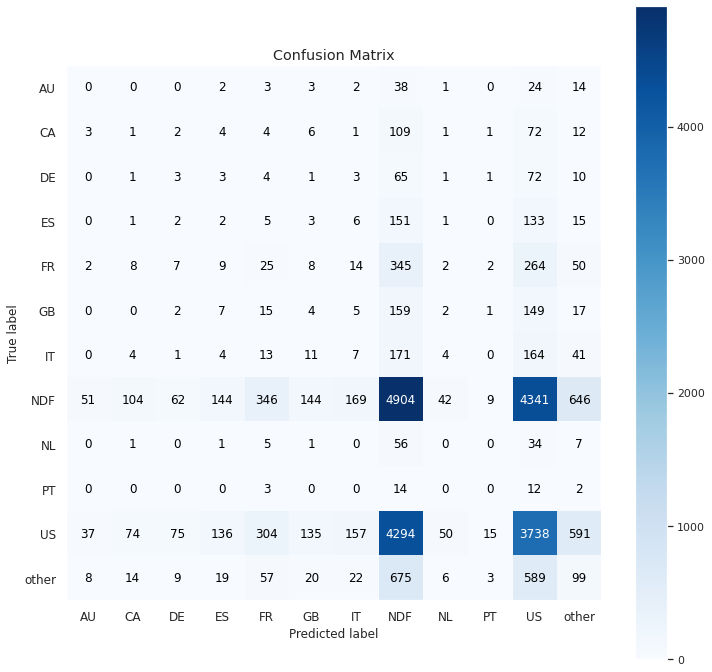

In [223]:
# Accuracy
acc_random = m.accuracy_score( y_test, yhat_random )
print( 'Accuracy: {}'.format( acc_random ) )

# Balanced Accuracy
balanced_accuracy_random = m.balanced_accuracy_score( y_test, yhat_random )
print( 'Balanced Accuracy: {}'.format( balanced_accuracy_random ) )

# Kappa Metrics
kappa_random = m.cohen_kappa_score( y_test, yhat_random )
print( 'Kappa Score: {}'.format( kappa_random ) )

# Classification Report
print( m.classification_report( y_test, yhat_random ) )

# Confusion Matrix
mt.plot_confusion_matrix( y_test, yhat_random, normalize=False, figsize=(12, 12) )


### 6.2 Neural Network - MLP

In [224]:
ohe = pp.OneHotEncoder()
y_train_nn = ohe.fit_transform( y_train.values.reshape( -1, 1 ) ).toarray()

In [225]:
# model definition
model = ml.Sequential()
model.add( l.Dense( 256, input_dim=x_train.shape[1], activation='relu' ) )
model.add( l.Dense( 12, activation='softmax') )

# model compile
model.compile( loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'] )

# train model
model.fit( x_train, y_train_nn, epochs=100 )

Epoch 1/100
3066/3066 [==============================] - 3s 950us/step - loss: 6.5740 - accuracy: 0.7327
Epoch 2/100
3066/3066 [==============================] - 3s 953us/step - loss: 2.4187 - accuracy: 0.7539
Epoch 3/100
3066/3066 [==============================] - 3s 964us/step - loss: 1.2433 - accuracy: 0.7839
Epoch 4/100
3066/3066 [==============================] - 3s 1ms/step - loss: 0.8586 - accuracy: 0.8112
Epoch 5/100
3066/3066 [==============================] - 3s 956us/step - loss: 0.7156 - accuracy: 0.8300
Epoch 6/100
3066/3066 [==============================] - 4s 1ms/step - loss: 0.6569 - accuracy: 0.8372
Epoch 7/100
3066/3066 [==============================] - 4s 1ms/step - loss: 0.6474 - accuracy: 0.8377
Epoch 8/100
3066/3066 [==============================] - 3s 1ms/step - loss: 0.6441 - accuracy: 0.8382
Epoch 9/100
3066/3066 [==============================] - 4s 1ms/step - loss: 0.6422 - accuracy: 0.8383
Epoch 10/100
3066/3066 [==============================] - 4s 1ms/

#### 6.2.1 NN Performance

In [226]:
# prediction
pred_nn = model.predict( x_test )

# invert prediction
yhat_nn = ohe.inverse_transform( pred_nn )

# prediction prepare
y_test_nn = y_test.to_numpy()
yhat_nn = yhat_nn.reshape( 1, -1 )[0]

Accuracy: 0.8384703196347032
Balanced Accuracy: 0.16664931639947256
Kappa Score: 0.7232441822459961


/home/victorpereira/.pyenv/versions/3.8.0/envs/airbnb_predict_first_booking/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

          AU       0.00      0.00      0.00        87
          CA       0.00      0.00      0.00       216
          DE       0.00      0.00      0.00       164
          ES       0.00      0.00      0.00       319
          FR       0.00      0.00      0.00       736
          GB       0.00      0.00      0.00       361
          IT       0.00      0.00      0.00       420
         NDF       1.00      1.00      1.00     10962
          NL       0.00      0.00      0.00       105
          PT       0.00      0.00      0.00        31
          US       0.71      1.00      0.83      9606
       other       0.00      0.00      0.00      1521

    accuracy                           0.84     24528
   macro avg       0.14      0.17      0.15     24528
weighted avg       0.72      0.84      0.77     24528



<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

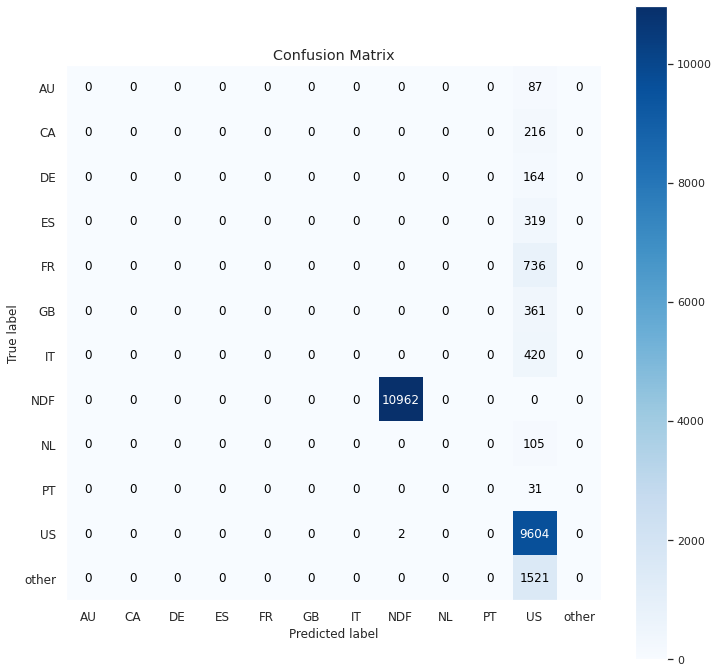

In [227]:
# Accuracy
acc_nn = m.accuracy_score( y_test_nn, yhat_nn )
print( 'Accuracy: {}'.format( acc_nn ) )

# Balanced Accuracy
balanced_accuracy_nn = m.balanced_accuracy_score( y_test_nn, yhat_nn )
print( 'Balanced Accuracy: {}'.format( balanced_accuracy_nn ) )

# Kappa Metrics
kappa_nn = m.cohen_kappa_score( y_test_nn, yhat_nn )
print( 'Kappa Score: {}'.format( kappa_nn ) )

# Classification Report
print( m.classification_report( y_test_nn, yhat_nn ) )

# Confusion Matrix
mt.plot_confusion_matrix( y_test_nn, yhat_nn, normalize=False, figsize=(12, 12) )


#### 6.2.2 NN Performance - Cross-Validation

In [149]:
# generate k-fold
num_folds = 5
kfold = ms.StratifiedKFold( n_splits=num_folds, shuffle=True, random_state=32 )

balanced_acc_list = []
kappa_acc_list = []

i = 1
for train_ix, val_ix in kfold.split( x_train, y_train ):
    print( 'Fold Number:{}/{}'.format( i, num_folds ) )
    
    # get fold
    x_train_fold = x_train.iloc[train_ix]
    y_train_fold = y_train.iloc[train_ix]
    
    x_val_fold = x_train.iloc[val_ix]
    y_val_fold = y_train.iloc[val_ix]
    
    # target hot-encoder
    ohe = pp.OneHotEncoder()
    y_train_fold_nn = ohe.fit_transform( y_train_fold.values.reshape( -1, 1 ) ).toarray()

    # model definition
    model = ml.Sequential()
    model.add( l.Dense( 256, input_dim=x_train.shape[1], activation='relu') )
    model.add( l.Dense( 12, activation='softmax' ) )

    # compile model
    model.compile( loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'] )

    # training model
    model.fit( x_train_fold, y_train_fold_nn, epochs=100, batch_size=32, verbose=0 )

    # prediction
    pred_nn = model.predict( x_val_fold )
    yhat_nn = ohe.inverse_transform( pred_nn )
    
    # prepare data
    y_test_nn = y_val_fold.to_numpy()
    yhat_nn = yhat_nn.reshape( 1, -1 )[0]

    # metrics
    ## Balanced Accuracy
    balanced_acc_nn = m.balanced_accuracy_score( y_test_nn, yhat_nn )
    balanced_acc_list.append( balanced_acc_nn )
    
    ## Kappa Metrics
    kappa_acc_nn = m.cohen_kappa_score( y_test_nn, yhat_nn )
    kappa_acc_list.append( kappa_acc_nn )
    
    i += 1

Fold Number:1/5
Fold Number:2/5
Fold Number:3/5
Fold Number:4/5
Fold Number:5/5


In [150]:
print( 'Avg Balanced Accuracy: {} +/- {}'.format( np.round( np.mean( balanced_acc_list ), 2 ), 
                                                 np.round( np.std( balanced_acc_list ), 4 ) ) )
print( 'Avg Kappa Accuracy: {} +/- {}'.format( np.round( np.mean( kappa_acc_list ), 4 ), 
                                              np.round( np.std( kappa_acc_list ), 4 ) ) )

Avg Balanced Accuracy: 0.11 +/- 0.0007
Avg Kappa Accuracy: 0.1893 +/- 0.0064
